In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Download real-time data for the stock (e.g., 'AAPL') for a specific date range
stock_data = yf.download('PANI.JK', start='2024-01-01', end='2024-11-19')
real_prices = stock_data['Close'].values
print(real_prices)

[*********************100%***********************]  1 of 1 completed

[[ 5025.]
 [ 4900.]
 [ 4910.]
 [ 4840.]
 [ 4700.]
 [ 4500.]
 [ 4580.]
 [ 4460.]
 [ 4500.]
 [ 4550.]
 [ 4580.]
 [ 4630.]
 [ 4570.]
 [ 4550.]
 [ 4670.]
 [ 4620.]
 [ 4700.]
 [ 4840.]
 [ 4800.]
 [ 4850.]
 [ 4840.]
 [ 4840.]
 [ 4890.]
 [ 4950.]
 [ 4850.]
 [ 4900.]
 [ 4890.]
 [ 5300.]
 [ 5500.]
 [ 5700.]
 [ 5550.]
 [ 5600.]
 [ 5525.]
 [ 5475.]
 [ 5525.]
 [ 5300.]
 [ 5250.]
 [ 5125.]
 [ 5300.]
 [ 5250.]
 [ 5250.]
 [ 5200.]
 [ 5125.]
 [ 5250.]
 [ 5225.]
 [ 5250.]
 [ 5450.]
 [ 5250.]
 [ 5250.]
 [ 5150.]
 [ 5150.]
 [ 5200.]
 [ 5200.]
 [ 5325.]
 [ 5500.]
 [ 5525.]
 [ 5450.]
 [ 5575.]
 [ 5350.]
 [ 5525.]
 [ 5475.]
 [ 5525.]
 [ 5550.]
 [ 5625.]
 [ 5375.]
 [ 5350.]
 [ 5125.]
 [ 5175.]
 [ 5275.]
 [ 5250.]
 [ 5150.]
 [ 5000.]
 [ 5000.]
 [ 4930.]
 [ 4730.]
 [ 4750.]
 [ 4840.]
 [ 4890.]
 [ 4900.]
 [ 4900.]
 [ 4890.]
 [ 4900.]
 [ 5325.]
 [ 5350.]
 [ 5600.]
 [ 5600.]
 [ 5575.]
 [ 5475.]
 [ 5475.]
 [ 5275.]
 [ 5125.]
 [ 5125.]
 [ 5075.]
 [ 5075.]
 [ 4920.]
 [ 4970.]
 [ 5000.]
 [ 4980.]
 [ 4930.]
 [ 4930.]


In [3]:
from tensorflow.keras.models import load_model

loaded_model = load_model("lstm_PANIJK_model.h5")


In [4]:
from sklearn.preprocessing import MinMaxScaler
window_size = 20 #high volatility
scaler = MinMaxScaler(feature_range=(0, 1))
# Prepare real-time stock data (use the same preprocessing as during training)
real_time_data = scaler.fit_transform(real_prices.reshape(-1, 1))  # Scale data if necessary
real_time_sequences = []  # Create sequences matching window_size

for i in range(len(real_time_data) - window_size):
    real_time_sequences.append(real_time_data[i:i + window_size])

real_time_sequences = np.array(real_time_sequences)
real_time_sequences = real_time_sequences.reshape(-1, window_size, 1)

# Predict
predicted_real_prices = loaded_model.predict(real_time_sequences)
predicted_real_prices = scaler.inverse_transform(predicted_real_prices)  # Reverse scaling


6/6 [==============================] - 2s 23ms/step


In [5]:
# Ensure the lengths of actual and predicted prices match
real_prices_trimmed = real_prices[window_size:]  # Trim to match prediction length

# MAPE Calculation
mape = np.mean(np.abs((real_prices_trimmed - predicted_real_prices.flatten()) / real_prices_trimmed)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Percentage Error (MAPE): 38.10%


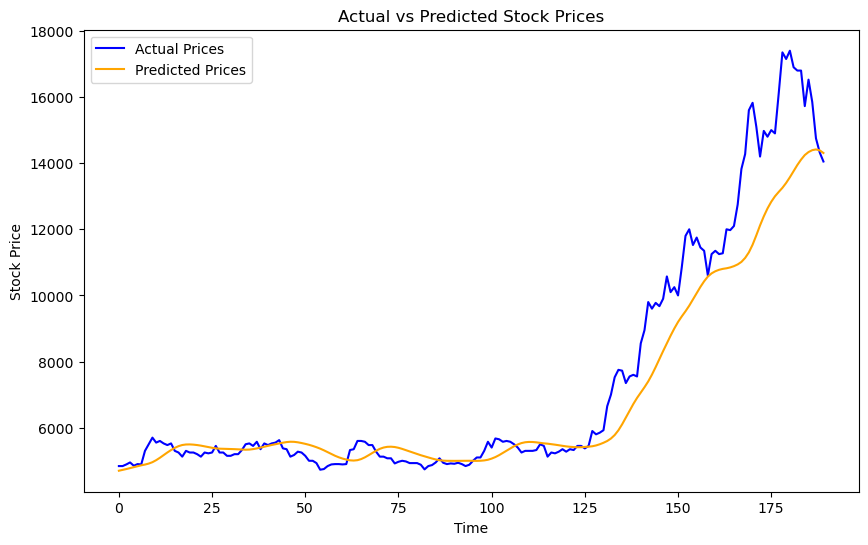

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(real_prices_trimmed, label="Actual Prices", color="blue")
plt.plot(predicted_real_prices, label="Predicted Prices", color="orange")
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [9]:
n_future_days = 90

# Take the last `window_size` data points from the scaled dataset
last_sequence = real_time_data[-window_size:]  # Assuming `real_time_data` is scaled
future_predictions = []

# Iteratively predict the next day
for _ in range(n_future_days):
    # Reshape the sequence to match the input shape: (1, window_size, 1)
    last_sequence_reshaped = last_sequence.reshape(1, window_size, 1)
    
    # Predict the next day
    next_prediction = loaded_model.predict(last_sequence_reshaped)
    
    # Store the prediction
    future_predictions.append(next_prediction[0, 0])  # Extract the scalar value
    
    # Append the prediction to the sequence and remove the first value to maintain window_size
    last_sequence = np.append(last_sequence[1:], next_prediction)

# Inverse transform the predictions to get the actual stock prices
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

print("Future Predictions for the Next 3 Months:")
print(future_predictions.flatten())


1/1 [==============================] - 0s 24ms/step
Future Predictions for the Next 3 Months:
[14183.162  14030.724  13862.48   13687.56   13514.431  13345.802
 13184.099  13029.765  12884.66   12748.914  12620.378  12498.9795
 12383.264  12273.165  12168.459  12067.415  11971.937  11880.196
 11791.135  11705.122  11622.182  11542.713  11466.329  11392.833
 11322.044  11253.802  11187.959  11124.391  11062.98   11003.623
 10946.226  10890.697  10836.96   10784.928  10734.528  10685.694
 10638.357  10592.451  10547.923  10504.711  10462.764  10422.027
 10382.454  10344.001  10306.625  10270.282  10234.937  10200.55
 10167.09   10134.5205 10102.809  10071.928  10041.846  10012.536
  9983.975   9956.133   9928.987   9902.513   9876.694   9851.505
  9826.927   9802.938   9779.522   9756.662   9734.342   9712.539
  9691.243   9670.439   9650.11    9630.242   9610.823   9591.84
  9573.28    9555.132   9537.382   9520.0205  9503.038   9486.421
  9470.163   9454.252   9438.679   9423.435   940

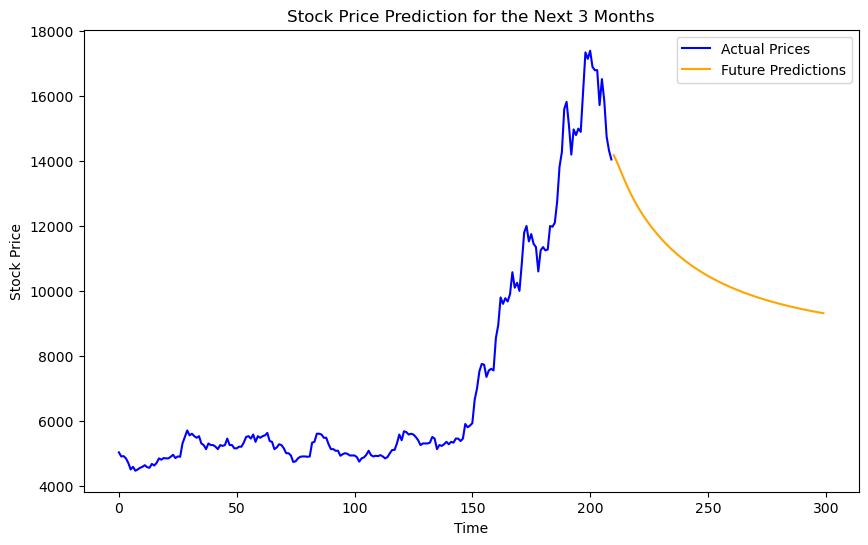

In [11]:
import matplotlib.pyplot as plt

# Create a time range for the predictions
prediction_days = np.arange(len(real_prices), len(real_prices) + n_future_days)

plt.figure(figsize=(10, 6))
plt.plot(real_prices, label="Actual Prices", color="blue")  # Historical prices
plt.plot(prediction_days, future_predictions, label="Future Predictions", color="orange")  # Predicted prices
plt.title("Stock Price Prediction for the Next 3 Months")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
